# Lab 4 - Randomized Experiments versus Observational Studies

## Introduction 
---

The focus of this lab is on using randomized experiments to answer causal questions. 
- For example, what is the effect of a policy change, raising or lowering prices, or really any change to how your business operates?

**Why is this challenging?** We want to observe a single unit in two different states. But we can't see the *counterfactual.*
- For example, to estimate the effect of vaccination on health outcomes, we would like to observe people who are identical except for vaccination status.
- If only older people get vaccinated, the difference in health outcomes between vaccinated and unvaccinated people is  a combination of the association between age and health, and the effect of the vaccination.

**Solution**: If we randomly assign people to a vaccine group (**treatment group**) or to a no vaccine group (**control group**), then, on average, vaccinated and unvaccinated participants would be equivalent in terms of age and other factors. In other words, the only difference between these groups is that one group was vaccinated, and the other wasn't.
&#8594; So we can attribute any difference in health outcomes to the **causal effect of vaccination (or "treatment effect'')**.

**This week:** We introduce standard RCTs where individuals (or some other unit) are randomly assigned to treatment and control.

**Next week:** We will talk more about experiment design under practical constraints, including situations where it is infeasible or unethical to force people into treatment and control groups and how to determine the size or duration of an experiment.

## Background: Illinois Workplace Wellness Study <a id='background'></a>
---
The Illinois Workplace Wellness Study is a large-scale RCT designed to measure the effects of workplace wellness programs on several employee outcomes, including medical spending, productivity, and well-being. As part of the study, researchers introduced a comprehensive wellness program (iThrive) at the University of Illinois, Urbana-Champaign.

iThrive includes the key components of workplace wellness programs: a biometric screening (which
provide clinical measures of health), a health risk assessment (which assess
lifestyle health habits), a variety of wellness activities, monetary incentives, and paid time off.

In July 2016, 12,459 employees were invited to enroll in the study by completing a 15-minute survey designed to measure baseline health wellness. 4,834 employees completed the study. We will refer to these respondents as the study participants. Study participants were randomly assigned to either the control group ($N = 1,534$) or the treatment group ($N = 3,300$). Employees in the treatment group are offered the opportunity to participate in iThrive.

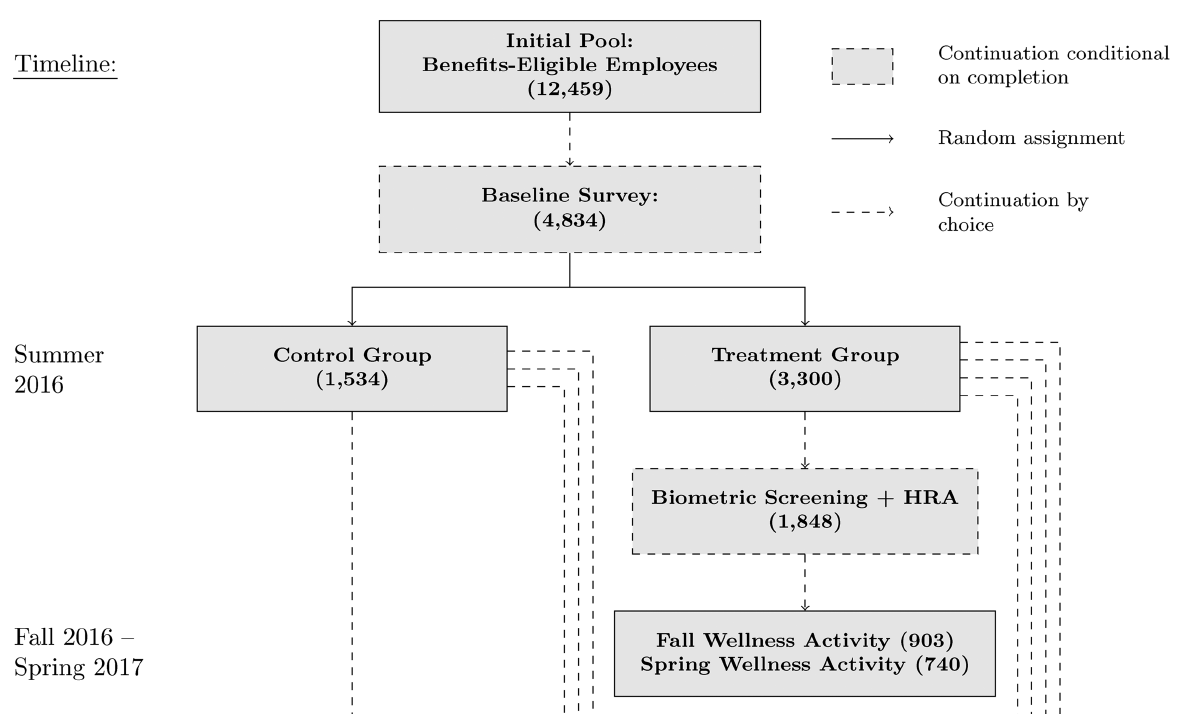

The first step of iThrive includes a biometric health screening and an online health risk assessment of lifestyle habits. Participants are provided a summary of their results and recommended areas of improvement.

Only participants that complete both the screening and heath risk assessment can participate in wellness activities. These wellness activities include:

- In-person classes on: chronic disease management, weight management, tai chi, physical fitness, financial wellness, and healthy workplace habits

- A tobacco quitline

Participants are given cash incentives for completing each step of the program.

We will analyze data on study participants from this experiment. The data include adminstrative HR records, survey responses, health insurance claims, and university gym visit records, covering the period July 2016 through January 2019.

## An Example in R
---

### Table of Contents

1. [Describing the Data](#data) <br>
2. [Selection](#selection) <br>
2. [Balance Checks](#balance) <br>
6. [Using RCT to Estimate Causal Effects](#rct) <br>
7. [Comparing to Observational Methods](#observational) <br>

### Describing the Data <a id='data'></a>

Let's start by opening the data.

In [166]:
# Load libraries
library(dplyr)
library(tidyr)
library(estimatr)
library(ggplot2)

In [167]:
# Open data and see
Wellness <- read.csv("Wellness.csv", header=TRUE)
head(Wellness)

,treat,hra_c_yr1,male,age50,age37_49,white,active_0716,cursmk_0716,chronic_0716,badhealth_0716,⋯,sickleave_0816_0717,sickleave_0816_0119,gym_0815_0716,gym_0816_0717,gym_0816_0119,terminated_0717,terminated_0119,screening2016_c,activity_f_c_yr1,activity_s_c_yr1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,0,NA,1,0,1,1,1,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1,1,0,0,0,0,0,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1,1,1,1,0,1,1,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1,1,0,0,1,1,1,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1,0,0,1,0,1,0,0,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1,1,0,0,1,0,0,0,1,1,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Here are the variables that are included in our data. They include information on employee demographics, program participation, baseline health, medican spending, gym use, and job-related information.

##### Employee demographics
- **`male`:** Male (0/1)
- **`age50`:** Ages 50 and over (0/1)
- **`age37_49`:** Ages 37-49 (0/1)
- **`white`:** White (0/1)

##### Program participation
- **`treat`:** Assigned to treatment group (0/1)
- **`hra_c_yr1`:** Completed health risk assessment (0/1)
- **`screening2016_c`:** Completed biometric screening (0/1)
- **`activity_f_c_yr1`:** Completed Fall 2016 wellness activity (0/1)
- **`activity_s_c_yr1`:** Completed Spring 2017 wellness activity (0/1)

##### Baseline health (survey-based)
- **`active_0716`:** Physically active (0/1)
- **`cursmk_0716`:** Current smoker (0/1)
- **`chronic_0716`:** Has at least 1 chronic condition (0/1)
- **`badhealth_0716`:** High blood pressure, cholesterol, or glucose (0/1)

##### Job satisfaction
- **`jobsatisf2_(date)`:** Very or somewhat satisifed with job at (surveyed at date) (0/1)
- **`mgmtsafety_(date)`:** Management places very high or some priority on health/safety (surveyed at date) (0/1)

##### Medical spending
- **`spend_(dates)`:** Average monthly medical spending (over period) ($)

##### Firm administrative data
- **`sickleave_(dates)`:** Sick leave (over period) (days/year)
- **`gym_(dates)`:** Campus rec visits (over period) (days/year)
- **`terminated_(date)`:** Job terminated as of (date)

### Selection <a id='selection'></a>

#### 1. Program Participation

First, we look at program participation rates. Recall that employees assigned to the treatment group are given the *option* to participate in iThrive, not mandated to. This is similar to how most workplace wellness programs work in practice. To understand whether iThrive affects employee outcomes, it's important to understand how many employees actually participate in the programming.

*Report participate rates for each program (HRA, biometric screening, any Fall wellness activity, any Spring wellness activity).*

In [168]:
Wellness_Treat <- Wellness[which(Wellness$treat==1),]

summarize(Wellness_Treat, 
    "HRA" = mean(hra_c_yr1, na.rm = TRUE),
    "Screening" = mean(screening2016_c, na.rm = TRUE),
    "Fall Activity" = mean(activity_f_c_yr1, na.rm = TRUE),
    "Spring Activity" = mean(activity_s_c_yr1, na.rm = TRUE)) 

HRA,Screening,Fall Activity,Spring Activity
<dbl>,<dbl>,<dbl>,<dbl>
0.56,0.5757576,0.2736364,0.2242424


These participation rates are similar to those reported in surveys by employers with workplace wellness programs (Mattke et al. 2013).

#### 2. Biometric Screening + HRA
The reason we want to run an experiment in the first place is that we're concerned about *selection bias*---the employees that self-select into the wellness program will differ from the employees that do not. If that weren't a problem, perhaps we wouldn't need an experiment after all. We could just compare the two groups and infer that any differences in outcomes between them could be attributed to iThrive.

Let's look for selection and compare employees that participate in iThrive to employees that choose not to. We will focus on employees in the treatment group, all of whom have the option to participate.

*Compare the baseline characteristics of treatment group employees that take the health risk assessment (`hra_c_yr1 == 1`) to treatment group employees that do not.*

In [169]:
Wellness_Treat %>%
    group_by(hra_c_yr1) %>%
    summarize("Male" = mean(male, na.rm = TRUE),
              "Ages 50 or Over" = mean(age50, na.rm = TRUE),
              "Ages 37-49" = mean(age37_49, na.rm = TRUE),
              "White" = mean(white, na.rm = TRUE),
              "Physically Active" = mean(active_0716, na.rm = TRUE),
              "Current Smoker" = mean(cursmk_0716, na.rm = TRUE),
              "Chronic Condition" = mean(chronic_0716, na.rm = TRUE),
              "High Blood Pressure, Cholesterol, or Glucose" = mean(badhealth_0716, na.rm = TRUE),
              "Satisfied with Job" = mean(jobsatisf2_0716, na.rm = TRUE),
              "Management Prioritizes Health" = mean(mgmtsafety_0716, na.rm = TRUE),
              "Medical Spending" = mean(spend_0715_0716, na.rm = TRUE),
              "Sick Leave" = mean(sickleave_0815_0716, na.rm = TRUE),
              "Gym Visits" = mean(gym_0815_0716, na.rm = TRUE))

hra_c_yr1,Male,Ages 50 or Over,Ages 37-49,White,Physically Active,Current Smoker,Chronic Condition,"High Blood Pressure, Cholesterol, or Glucose",Satisfied with Job,Management Prioritizes Health,Medical Spending,Sick Leave,Gym Visits
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.4600551,0.3415978,0.3278237,0.8360882,0.3898072,0.08821502,0.7121212,0.2988981,0.8319559,0.7747934,527.2731,5.837923,5.559917
1,0.4020563,0.3149351,0.3360390,0.8354978,0.3750000,0.04761905,0.7364719,0.2922078,0.8548998,0.7872225,423.5847,6.358665,7.738095


*How do the two groups differ? Should we be concerned about selection bias? If you're concerned about bias, do you expect it to make workplace wellness programs look more or less effective?*

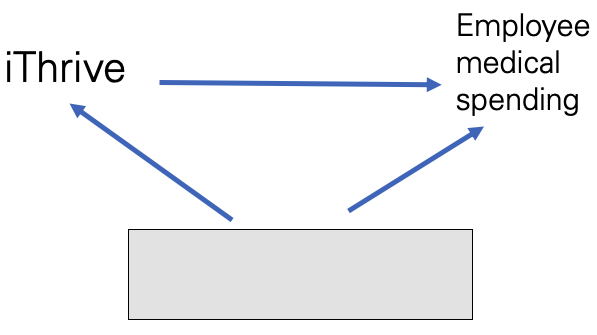

We should also check whether these differences between employees that self-select into the program and those that do not are statistically significant. One way to do that is to use a regression model. *Let's use a regression model to compare spending for the two groups.*

In [170]:
summary(lm(spend_0715_0716 ~ hra_c_yr1, data = Wellness_Treat))


Call:
lm(formula = spend_0715_0716 ~ hra_c_yr1, data = Wellness_Treat)

Residuals:
    Min      1Q  Median      3Q     Max 
 -527.3  -416.4  -300.9     4.0 19414.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   527.27      35.07  15.036   <2e-16 ***
hra_c_yr1    -103.69      45.18  -2.295   0.0218 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1034 on 2186 degrees of freedom
  (11012 observations deleted due to missingness)
Multiple R-squared:  0.002403,	Adjusted R-squared:  0.001947 
F-statistic: 5.267 on 1 and 2186 DF,  p-value: 0.02183


While there are clear differences between employees that self-select into the program and those that do not, at least we have data on these differences. In principle, we could *control for them*. We will return to this point later.

### Balance Checks <a id='balance'></a>

The point of randomization is to guarantee that employees in the treatment and control groups are essentially identical, on average. Let's confirm that randomization successfully achieved this goal, and compare baseline characteristics for the randomly assigned treatment and control groups.

*Compare means of the demographic and health survey measures for the treatment and control groups.*

In [171]:
Wellness %>%
    group_by(treat) %>%
    summarize("Male" = mean(male, na.rm = TRUE),
              "Ages 50 or Over" = mean(age50, na.rm = TRUE),
              "Ages 37-49" = mean(age37_49, na.rm = TRUE),
              "White" = mean(white, na.rm = TRUE),
              "Physically Active" = mean(active_0716, na.rm = TRUE),
              "Current Smoker" = mean(cursmk_0716, na.rm = TRUE),
              "Chronic Condition" = mean(chronic_0716, na.rm = TRUE),
              "High BP, Chol, or Glucose" = mean(badhealth_0716, na.rm = TRUE))

treat,Male,Ages 50 or Over,Ages 37-49,White,Physically Active,Current Smoker,Chronic Condition,"High BP, Chol, or Glucose"
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.4256845,0.3233377,0.3402868,0.8409387,0.3591917,0.07170795,0.7288136,0.3083442
1,0.4275758,0.3266667,0.3324242,0.8357576,0.3815152,0.06547439,0.7257576,0.2951515


There are some differences between the two groups, though they appear to be small. Under randomization, these differences should just be due to random chance. We can check this by conducting a hypothesis test.

The null hypothesis we will test is that the baseline characteristics are uncorrelated with `treat`. We will test this hypothesis using this regression model:

`treat` = $b_{0}$ + $b_{1}$ `male` + $b_{2}$ `age50` + $b_{3}$ `age37_49` + $b_{4}$ `white` + $b_{5}$ `active_0716` + $b_{6}$ `cursmk_0716` + $b_{7}$ `chronic_0716` + $b_{8}$ `badhealth_0716`

and the null hypothesis we will test is that $b_{1} = b_{2} = ... = b_{8} = 0$.

In [172]:
# We regress treatment on baseline covariates
summary(lm(treat ~ male + age50 + age37_49 + white + active_0716 + cursmk_0716 + chronic_0716 + badhealth_0716, data = Wellness))


Call:
lm(formula = treat ~ male + age50 + age37_49 + white + active_0716 + 
    cursmk_0716 + chronic_0716 + badhealth_0716, data = Wellness)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7108 -0.6706  0.3075  0.3202  0.3582 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     6.901e-01  2.194e-02  31.455   <2e-16 ***
male           -8.419e-05  1.387e-02  -0.006    0.995    
age50          -3.564e-04  1.717e-02  -0.021    0.983    
age37_49       -7.520e-03  1.650e-02  -0.456    0.649    
white          -1.030e-02  1.841e-02  -0.559    0.576    
active_0716     1.916e-02  1.427e-02   1.343    0.179    
cursmk_0716    -1.966e-02  2.674e-02  -0.735    0.462    
chronic_0716    1.533e-03  1.588e-02   0.097    0.923    
badhealth_0716 -1.073e-02  1.550e-02  -0.692    0.489    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4657 on 4824 degrees of freedom
  (14503 observations deleted due to miss

**Lessons:**

- Randomization does not guarantee exact balance.

**When to be worried:** 

- Difference are significant.

 - Caveats: 
     - Significance does not *necessarily* mean imbalance will bias treatment effects. 
     - And insignificant differences *can* still produce a meaningful bias in treatment effects.

- Differences are large in magnitude, especially on important variables (i.e., that you think correlate with your outcome).

### Using RCT to Estimate Causal Effects <a id='rct'></a>

#### 1. Comparing Means

Now let's move on to what we're ultimately interested in: the causal effects of workplace wellness programs on employee outcomes.

We will focus on five outcomes that capture different aspects of how workplace wellness programs work. 

1. medical spending (`spend_0816_0717`). Recall that one major selling point of these programs is that they can actually save employers money on health-related spending.

2. sick leave (`sickleave_0816_0717`). We can interpret this as an indirect form of health-related spending.

3. gym visits (`gym_0816_0717`). Here we can measure whether these programs affect employee's health-related behaviors.

4. turnover (`terminated_0717`).

5. employee perceptions about whether their employer cares about employee health and safety (`mgmtsafety_0717`).

In [173]:
Wellness %>%
    group_by(treat) %>%
    summarize("Medical Spending" = mean(spend_0816_0717, na.rm = TRUE),
             "Sick Leave" = mean(sickleave_0816_0717, na.rm = TRUE),
             "Gym Visits (Days/Year)" = mean(gym_0816_0717, na.rm = TRUE),
             "Management Prioritizes Health/Safety" = mean(mgmtsafety_0717, na.rm = TRUE),
             "Job Terminated" = mean(terminated_0717, na.rm = TRUE))

treat,Medical Spending,Sick Leave,Gym Visits (Days/Year),Management Prioritizes Health/Safety,Job Terminated
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,594.8318,6.054892,5.881356,0.7508651,0.1219035
1,563.6499,6.272346,5.819697,0.8082988,0.1093939


#### 2a. Regression-Based Approach

If there are any differences, they are small. Let's conduct hypothesis tests for whether any treatment effects are statistically significant using regression.

In [174]:
# medical spending; spend_0816_0717
summary(lm(spend_0816_0717 ~ treat , data = Wellness))


Call:
lm(formula = spend_0816_0717 ~ treat, data = Wellness)

Residuals:
   Min     1Q Median     3Q    Max 
  -595   -518   -381    -38  33469 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   594.83      44.80  13.279   <2e-16 ***
treat         -31.18      54.26  -0.575    0.566    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1438 on 3237 degrees of freedom
  (16097 observations deleted due to missingness)
Multiple R-squared:  0.000102,	Adjusted R-squared:  -0.0002069 
F-statistic: 0.3303 on 1 and 3237 DF,  p-value: 0.5655


In [175]:
# sick leave; sickleave_0816_0717
summary(lm(sickleave_0816_0717 ~ treat , data = Wellness))


Call:
lm(formula = sickleave_0816_0717 ~ treat, data = Wellness)

Residuals:
   Min     1Q Median     3Q    Max 
-6.272 -6.055 -2.272  3.728 97.728 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.0549     0.1966  30.804   <2e-16 ***
treat         0.2175     0.2379   0.914    0.361    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.699 on 4832 degrees of freedom
  (14502 observations deleted due to missingness)
Multiple R-squared:  0.0001729,	Adjusted R-squared:  -3.404e-05 
F-statistic: 0.8355 on 1 and 4832 DF,  p-value: 0.3607


In [176]:
# gym visits; gym_0816_0717
summary(lm(gym_0816_0717 ~ treat , data = Wellness))


Call:
lm(formula = gym_0816_0717 ~ treat, data = Wellness)

Residuals:
    Min      1Q  Median      3Q     Max 
 -5.881  -5.881  -5.820  -5.820 297.119 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.88136    0.60702   9.689   <2e-16 ***
treat       -0.06166    0.73468  -0.084    0.933    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.77 on 4832 degrees of freedom
  (14502 observations deleted due to missingness)
Multiple R-squared:  1.458e-06,	Adjusted R-squared:  -0.0002055 
F-statistic: 0.007044 on 1 and 4832 DF,  p-value: 0.9331


In [177]:
# turnover; terminated_0717
summary(lm(terminated_0717 ~ treat , data = Wellness))


Call:
lm(formula = terminated_0717 ~ treat, data = Wellness)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1219 -0.1219 -0.1094 -0.1094  0.8906 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.121904   0.008095  15.059   <2e-16 ***
treat       -0.012510   0.009797  -1.277    0.202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.317 on 4832 degrees of freedom
  (14502 observations deleted due to missingness)
Multiple R-squared:  0.0003373,	Adjusted R-squared:  0.0001304 
F-statistic:  1.63 on 1 and 4832 DF,  p-value: 0.2017


In [184]:
# management prioritizes health/safety; mgmtsafety_0717
summary(lm(mgmtsafety_0717 ~ treat , data = Wellness))


Call:
lm(formula = mgmtsafety_0717 ~ treat, data = Wellness)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8083  0.1917  0.1917  0.1917  0.2491 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.75087    0.01196  62.763  < 2e-16 ***
treat        0.05743    0.01455   3.947 8.08e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4068 on 3564 degrees of freedom
  (15770 observations deleted due to missingness)
Multiple R-squared:  0.004351,	Adjusted R-squared:  0.004072 
F-statistic: 15.58 on 1 and 3564 DF,  p-value: 8.08e-05


Most of the treatment effects are not different from zero.

#### 2b. Adding Controls

Sometimes we can improve the precision of our estimates by **adjusting for covariates**. In other words, we run a regression of the form:

$y_i = \alpha + \beta D_i + \gamma X_i+\varepsilon_i$.

Where $X_i$ is a set of covariates (like demographics or baseline medical spending) for individual $i$.

Let's look at medical spending as the outcome and see what happens if we control for employee demographics (sex, age, race) and baseline medical spending.

In [179]:
# spend_0816_0717
summary(lm(spend_0816_0717 ~ treat, data = Wellness))


Call:
lm(formula = spend_0816_0717 ~ treat, data = Wellness)

Residuals:
   Min     1Q Median     3Q    Max 
  -595   -518   -381    -38  33469 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   594.83      44.80  13.279   <2e-16 ***
treat         -31.18      54.26  -0.575    0.566    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1438 on 3237 degrees of freedom
  (16097 observations deleted due to missingness)
Multiple R-squared:  0.000102,	Adjusted R-squared:  -0.0002069 
F-statistic: 0.3303 on 1 and 3237 DF,  p-value: 0.5655


In [180]:
summary(lm(spend_0816_0717 ~ treat + spend_0715_0716 + male + age50 + age37_49 + white, data = Wellness))


Call:
lm(formula = spend_0816_0717 ~ treat + spend_0715_0716 + male + 
    age50 + age37_49 + white, data = Wellness)

Residuals:
   Min     1Q Median     3Q    Max 
-12425   -302   -166     14  33683 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      246.85185   76.30176   3.235  0.00123 ** 
treat             -5.57465   48.14382  -0.116  0.90783    
spend_0715_0716    0.65991    0.02149  30.709  < 2e-16 ***
male            -140.67505   45.55494  -3.088  0.00203 ** 
age50            115.89876   57.09485   2.030  0.04245 *  
age37_49          36.16330   54.95779   0.658  0.51057    
white             40.86517   62.14308   0.658  0.51084    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1264 on 3158 degrees of freedom
  (16171 observations deleted due to missingness)
Multiple R-squared:  0.2449,	Adjusted R-squared:  0.2435 
F-statistic: 170.7 on 6 and 3158 DF,  p-value: < 2.2e-16


| Sample size |  Controls    | Estimated treatment effect (Standard error) | p-value |
| ----------- |  ----------- | -----------   |-----------   |
| 3,165       |  No         |  -31.18    (54.24)  |  0.588        |
| 3,165       |  Yes         | -5.57  (49.37) | 0.910        |

Note that the standard error for `treat` decreases. This is useful because it makes our treatment effect estimate more precise and the confidence interval more narrow. As we'll discuss next week, it is also useful because it allows us to run experiments with smaller samples (saving $ or time). 

In this case, adding controls does not change our conclusion: the estimated treatment effect is still approximately zero.

### Comparing to Observational Methods <a id='observational'></a>

These are striking findings. The prior literature has consistently documented that workplace wellness programs reduce employee medical spending, reduce sick leave, and improve retention. Yet this randomized experiment that iThrive has essentially no detectable effect of employee outcomes, except for convincing employees that the employer cares about employee health and safety.

What could be driving this apparent contradiction? One possibility is that the *methods used* are responsible: most prior work is from **observational studies** rather than randomized controlled trials. In these studies, researchers try to account for selection bias by controlling for potential confounding factors rather than running an experiment.

We can gauge whether this could be the explanation by treating the data we have as though it's observational data (rather than from an experiment). In particular, among employees in the treatment group, we can compare outcomes for employees that choose to participate in iThrive and employees to do not, while controlling for the whatever differences we see between them.

For this exercise, let's focus on gym visits and employee turnover.

In [181]:
# gym visits: gym_0816_0717; dependent variable: hra_c_yr1; control variables: male + gym_0815_0716
summary(lm(gym_0816_0717 ~ hra_c_yr1 + male + gym_0815_0716, data = Wellness_Treat))

summary(lm(gym_0816_0717 ~ treat, data = Wellness))


Call:
lm(formula = gym_0816_0717 ~ hra_c_yr1 + male + gym_0815_0716, 
    data = Wellness_Treat)

Residuals:
     Min       1Q   Median       3Q      Max 
-170.471   -1.717   -0.935    0.945  151.096 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.944819   0.392914  -2.405   0.0162 *  
hra_c_yr1      1.879722   0.446755   4.208 2.65e-05 ***
male           0.959355   0.449783   2.133   0.0330 *  
gym_0815_0716  0.781993   0.008674  90.151  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.7 on 3296 degrees of freedom
  (9900 observations deleted due to missingness)
Multiple R-squared:  0.7159,	Adjusted R-squared:  0.7156 
F-statistic:  2769 on 3 and 3296 DF,  p-value: < 2.2e-16



Call:
lm(formula = gym_0816_0717 ~ treat, data = Wellness)

Residuals:
    Min      1Q  Median      3Q     Max 
 -5.881  -5.881  -5.820  -5.820 297.119 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.88136    0.60702   9.689   <2e-16 ***
treat       -0.06166    0.73468  -0.084    0.933    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.77 on 4832 degrees of freedom
  (14502 observations deleted due to missingness)
Multiple R-squared:  1.458e-06,	Adjusted R-squared:  -0.0002055 
F-statistic: 0.007044 on 1 and 4832 DF,  p-value: 0.9331


In [182]:
# turnover: terminated_0717
summary(lm(terminated_0717 ~ hra_c_yr1 + male + gym_0815_0716, data = Wellness_Treat))

summary(lm(terminated_0717 ~ treat, data = Wellness))


Call:
lm(formula = terminated_0717 ~ hra_c_yr1 + male + gym_0815_0716, 
    data = Wellness_Treat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30569 -0.14911 -0.07065 -0.06745  0.93255 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.1523187  0.0095691  15.918  < 2e-16 ***
hra_c_yr1     -0.0816647  0.0108804  -7.506 7.82e-14 ***
male          -0.0032089  0.0109541  -0.293  0.76959    
gym_0815_0716  0.0006165  0.0002113   2.918  0.00355 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3094 on 3296 degrees of freedom
  (9900 observations deleted due to missingness)
Multiple R-squared:  0.01878,	Adjusted R-squared:  0.01788 
F-statistic: 21.02 on 3 and 3296 DF,  p-value: 1.731e-13



Call:
lm(formula = terminated_0717 ~ treat, data = Wellness)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1219 -0.1219 -0.1094 -0.1094  0.8906 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.121904   0.008095  15.059   <2e-16 ***
treat       -0.012510   0.009797  -1.277    0.202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.317 on 4832 degrees of freedom
  (14502 observations deleted due to missingness)
Multiple R-squared:  0.0003373,	Adjusted R-squared:  0.0001304 
F-statistic:  1.63 on 1 and 4832 DF,  p-value: 0.2017


Based on observational methods, iThrive increases gym visits by about 2 visits per year and reduces termination rates by 8 percentage points. Yet the experiment indicates that iThrive has no effect on either.

The discrepancy between the conclusions drawn from observational and experimental methods were discussed in the New York Times article.

This example demonstrates the power of randomized experiments. Even with relatively detailed controls, we get the wrong answer without randomization. Simply controlling for observed differences between those that do and do not participate in wellness programs is not enough.